In [1]:
import os
from sys import getsizeof
from time import sleep
import json
import re
import inspect
from warnings import filterwarnings

import numpy as np
import nltk
import matplotlib.pyplot as plt
import torch
from transformers import (
	BartTokenizer, BartForConditionalGeneration,
	T5Tokenizer, T5ForConditionalGeneration,
	PegasusForConditionalGeneration, PegasusTokenizerFast,
	GPT2TokenizerFast,
)
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from dotenv import load_dotenv

from utils.helpers import *
from utils.encoders import *
from utils.pipelines import *
from utils.trainer_utils import *
from utils.evaluator_utils import *

In [2]:
inf = float("inf")
filterwarnings("ignore")
device = get_device()
# device = "cpu"
load_dotenv()

True

In [3]:
data_dir = "/Users/naman/Workspace/Data/Long-Document-Summarization"
data_dir = "/home/nchibbar/Data"

crs_files = os.listdir(crs_dir := f"{data_dir}/GovReport/crs")
gao_files = os.listdir(gao_dir := f"{data_dir}/GovReport/gao")

print(f"crs files: {len(crs_files)}, gao files: {len(gao_files)}")

out_dir = f"{data_dir}/GovReport/processed"

crs files: 7238, gao files: 12228


In [4]:
# Sentence transformer
# Automatically loads into gpu if available
sent_dir = f"{data_dir}/Models/Sent-Transformer"
sent_encoder = SentenceTransformer(sent_dir).to("cpu")

# BART
bart_dir = f"{data_dir}/Models/BART"
bart_tokenizer = BartTokenizer.from_pretrained(bart_dir)
bart_model = BartForConditionalGeneration.from_pretrained(bart_dir)
bart_context_size = bart_model.config.max_position_embeddings

# T5
t5_dir = f"{data_dir}/Models/T5"
t5_tokenizer = T5Tokenizer.from_pretrained(t5_dir)
t5_model = T5ForConditionalGeneration.from_pretrained(t5_dir)
t5_context_size = t5_model.config.n_positions

# Pegasus
pegasus_dir = f"{data_dir}/Models/PEGASUS"
pegasus_tokenizer = PegasusTokenizerFast.from_pretrained(pegasus_dir)
pegasus_model = PegasusForConditionalGeneration.from_pretrained(pegasus_dir)
pegasus_context_size = pegasus_model.config.max_position_embeddings

# GPT 3.5 turbo tokenizer
gpt_dir = f"{data_dir}/Models/GPT-3.5-turbo-tokenizer"
gpt_tokenizer = GPT2TokenizerFast.from_pretrained(gpt_dir)
gpt_model = "gpt-3.5-turbo"
gpt_context_size = 4096

bart_context_size, t5_context_size, pegasus_context_size

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


(1024, 4096, 512)

In [5]:
preprocessor = TextProcessor(preprocessing=True)
postprocessor = None

## GovReport

In [ ]:
def combine_subsections(sections):
	text = ""
	for sec in sections:
		sec_text = "\n\n".join(sec["paragraphs"])
		if sec["section_title"]:
			sec_text = f"Section {sec["section_title"]}:\n\n{sec_text}"
		text = f"{text}\n\n{sec_text}" if text else sec_text
		if sec["subsections"]:
			sub_text = combine_subsections(sec["subsections"])
			text = f"{text}\n\n{sub_text}" if text else sub_text
	return text

In [ ]:
num_crs_files = len(crs_files)
for i, file in enumerate(crs_files):
	full_path = os.path.join(crs_dir, file)
	with open(full_path) as fp:
		data = json.load(fp)
	clear_stdout()
	print(f"{num_crs_files - i} files left", end="")
	text = f"{data["title"]}\n\n"
	text += combine_subsections([data["reports"]])
	summary = " ".join(data["summary"])
	summary = preprocessor.process(summary)
	with open(f"{out_dir}/{file}", "w") as fp:
		json.dump({
			"text": text,
			"summary": summary
		}, fp)

In [ ]:
for file in gao_files:
	file = os.path.join(gao_dir, file)
	with open(file) as fp:
		data = json.load(fp)
	text = combine_subsections(data["report"])
	text = preprocessor.process(text)
	print(data["highlight"])
	summary = "\n".join(data["highlight"])
	summary = preprocessor.process(summary)
	with open(f"{out_dir}/{file}", "w") as fp:
		json.dump({
			"text": text,
			"summary": summary
		}, fp)

## BigPatent

In [ ]:
bigpatent_dir = f"{data_dir}/BigPatent/train/a"

bigpatent_files = os.listdir(bigpatent_dir)

word_counts = []
for file in bigpatent_files:
	with open(f"{bigpatent_dir}/{file}") as fp:
		for line in fp.readlines():
			data = json.loads(line)
			text = data["description"]
			word_counts.append(count_words(text))

bins = int(len(word_counts)**.5)
plt.hist(word_counts, bins=bins)
plt.show()

In [ ]:
np.max(word_counts)

## Rough

In [6]:
min_words = 70_000
max_words = inf
max_texts = 10
texts, summaries = [], []
num_texts = 0
for file in crs_files:
	with open(f"{out_dir}/{file}") as fp:
		data = json.load(fp)
	if min_words < count_words(data["text"]) < max_words:
		texts.append(data["text"])
		summaries.append(data["summary"])
		num_texts += 1
	if num_texts == max_texts:
		break

len(texts)

2

In [7]:
segment_min_words = 20
text_segmenter = TextSegmenter(nltk.sent_tokenize, segment_min_words)

In [8]:
min_tokens_frac = .5
min_summary_tokens = 400
head_size = .5
threshold = .7
boost = .03
seed = 69
system_prompt = "You will be given some segments of a very long document. Your task is to summarize the entire document as a whole by extracting key information and ideas from the segments. Generate a detailed, concise, and coherent summary in 500 words. Do not refer to the document in the summary in any way."

sent_encoder.to(device)

bart_encoders = [
	TruncateMiddle(
		bart_tokenizer, bart_context_size, head_size, preprocessor, True
	),
	UniformSampler(
		bart_tokenizer, min_tokens_frac * bart_context_size, bart_context_size,
		text_segmenter, preprocessor, True, seed
	),
	SegmentSampler(
		bart_tokenizer, min_tokens_frac * bart_context_size, bart_context_size,
		text_segmenter, sent_encoder, preprocessor, True, threshold, boost, seed
	),
	RemoveRedundancy(
		bart_tokenizer, min_tokens_frac * bart_context_size, bart_context_size,
		text_segmenter, sent_encoder, preprocessor, True, threshold, seed
	)
]
t5_encoders = [
	TruncateMiddle(
		t5_tokenizer, t5_context_size, head_size, preprocessor, True
	),
	UniformSampler(
		t5_tokenizer, min_tokens_frac * bart_context_size, t5_context_size,
		text_segmenter, preprocessor, True, seed
	),
	SegmentSampler(
		t5_tokenizer, min_tokens_frac * bart_context_size, t5_context_size,
		text_segmenter, sent_encoder, preprocessor, True, threshold, boost, seed
	),
	RemoveRedundancy(
		t5_tokenizer, min_tokens_frac * bart_context_size, t5_context_size,
		text_segmenter, sent_encoder, preprocessor, True, threshold, seed
	)
]
gpt_encoders = [
	TruncateMiddle(
		gpt_tokenizer, gpt_context_size, head_size, preprocessor, True
	),
	UniformSampler(
		gpt_tokenizer, min_tokens_frac * gpt_context_size, gpt_context_size,
		text_segmenter, preprocessor, True, seed
	),
	SegmentSampler(
		gpt_tokenizer, min_tokens_frac * gpt_context_size, gpt_context_size,
		text_segmenter, sent_encoder, preprocessor, True, threshold, boost, seed
	),
	RemoveRedundancy(
		gpt_tokenizer, min_tokens_frac * gpt_context_size, gpt_context_size,
		text_segmenter, sent_encoder, preprocessor, True, threshold, seed
	)
]
bart_pipelines = [
	SummarizationPipeline(
		bart_model, enc, postprocessor, min_summary_tokens,
		bart_context_size, device
	) for enc in bart_encoders
]
t5_pipelines = [
	SummarizationPipeline(
		t5_model, enc, postprocessor, min_summary_tokens,
		t5_context_size, device
	) for enc in t5_encoders
]
gpt_pipelines = [
	OpenAIPipeline(
		gpt_model, enc, system_prompt=system_prompt
	) for enc in gpt_encoders
]
pipelines = bart_pipelines + t5_pipelines

In [15]:
encodings1 = bart_encoders[1](texts, return_batch=False)
encodings2 = bart_encoders[2](texts, return_batch=False)

token_lengths1 = [len(enc) for enc in encodings1]
token_lengths2 = [len(enc) for enc in encodings2]

avg_tokens1 = np.mean(token_lengths1)
avg_tokens2 = np.mean(token_lengths2)

avg_tokens1, avg_tokens2

(749.5, 735.0)

In [ ]:
for i, text in enumerate(texts):
	print(f"Processing text {i + 1}")
	bart_encoders[3](text, return_batch=False)

In [ ]:
text = preprocessor(texts[3])
text = text_segmenter(text)

[count_words(seg) for seg in text]

In [9]:
text = texts[1]
text = preprocessor(text)
count_words(text)

73246

In [10]:
my_stop_words = [
	"also", "however", "therefore", "thus", "hence", "moreover",
	"must", "may", "might", "could", "would", "shall", "need",
	"needs", "given", "since", "though",
]
for word in my_stop_words:
	if word in nltk.corpus.stopwords.words("english"):
		print(word)

stop_words = nltk.corpus.stopwords.words("english") + my_stop_words
stop_words += [
	word.capitalize()
	for word in stop_words
	if not word.istitle()
]

len(stop_words)

392

In [12]:
keywords_preprocessor = TextProcessor(
	only_words_nums = True,
	remove_nums = True
)

text_keywords = get_keywords(
	text,
	stop_words = stop_words,
	preprocessor = keywords_preprocessor
)

text_keywords

['financial',
 'billion',
 'crisis',
 'US',
 'countries',
 'government',
 'economic',
 'banks',
 'IMF',
 'China',
 'global',
 'United',
 'economy',
 'Bank',
 'markets',
 'market',
 'growth',
 'States',
 'European',
 'stimulus']

In [12]:
keywords_vec = sent_encoder.encode(" ".join(text_keywords))

segment_similarities = []
segments = text_segmenter(text)
for segment in segments:
	segment_vec = sent_encoder.encode(segment)
	segment_similarities.append(
		keywords_vec @ segment_vec
	)

segment_similarities

[0.5087323,
 0.31412268,
 0.42385107,
 0.38462245,
 0.39949688,
 0.40291756,
 0.4064793,
 0.3320877,
 0.2817063,
 0.3819891,
 0.43558234,
 0.3503595,
 0.34029588,
 0.39509365,
 0.33220628,
 0.48161525,
 0.39366293,
 0.2780938,
 0.39710695,
 0.46799344,
 0.376144,
 0.26847208,
 0.12157059,
 0.2683338,
 0.39711612,
 0.49235654,
 0.43655294,
 0.55438876,
 0.46940482,
 0.35324788,
 0.4461823,
 0.3173254,
 0.41072786,
 0.36700398,
 0.41445583,
 0.35214165,
 0.1902087,
 0.286025,
 0.13096064,
 0.20859425,
 0.03328281,
 0.2003568,
 0.1734933,
 0.16377819,
 0.11001223,
 0.13316962,
 0.2011598,
 0.46279424,
 0.4596409,
 0.42880607,
 0.45569068,
 0.42798108,
 0.23360702,
 0.46032944,
 0.35720992,
 0.40242657,
 0.26050115,
 0.40356386,
 0.40613547,
 0.31893802,
 0.3422554,
 0.40949938,
 0.39509344,
 0.36719924,
 0.35781807,
 0.28919172,
 0.21282825,
 0.33405596,
 0.37637442,
 0.26593393,
 0.25659642,
 0.27755123,
 0.41967025,
 0.35555887,
 0.4852451,
 0.28947666,
 0.28974143,
 0.18432653,
 0.3787

In [22]:
probs = torch.nn.functional.softmax(
	torch.tensor(segment_similarities) * 10
).numpy()

probs

array([0.00217802, 0.00031109, 0.00093202, ..., 0.00060586, 0.0003215 ,
       0.00049494], dtype=float32)

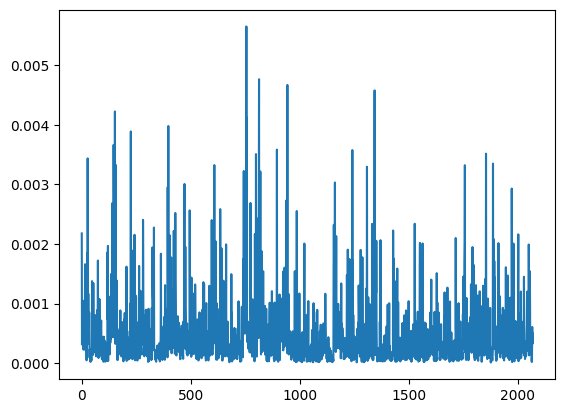

In [23]:
plt.plot(probs)
plt.show()

In [44]:
selected = np.random.choice(segments, size=2, p=probs, replace=False)
selected

array(['An international levy is an attractive idea, but practical changes are more likely to be implemented at the country level. Oxford Analytica. February 17.',
       'Many investors, who not too long ago had heeded financial advisors who were touting the long term returns from investing in the BRICs (Brazil, Russia, India, and China), pulled their money out nearly as fast as they had put it in.'],
      dtype='<U1028')

In [21]:
[
	segments[i]
	for i, sim in enumerate(segment_similarities)
	if sim < 0
]

['"There is a lot of traction for this kind of idea," said Representative Eric Cantor of Virginia, the Republican whip.',
 "Instead of awarding large cash salaries, Kenneth Feinberg is planning to shift a chunk of an employee's annual salary into stock that cannot be touched for several years.",
 'The survey also indicated that poppy cultivation in the main producing regions of the south and the southwest fell for the first time in five years.']

In [35]:
re.sub(r"(\b|\+)[\d+-]+\b", "", "+1234-5678 +90")

' '